# Applications to Kang-Schafer (2007) DGP

In [1]:
import cbpys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

In [2]:
np.random.seed(123)
simulation = cbpys.kang_schafer(size=2000)
df = pd.DataFrame(
    np.column_stack([
        simulation.treatment, simulation.covariates,
        simulation.transformed_covariates, simulation.outcome
    ]))
df.columns = [
    "treatment", "z1", "z2", "z3", "z4", "x1", "x2", "x3", "x4", "outcome"
]
df.head()

,treatment,z1,z2,z3,z4,x1,x2,x3,x4,outcome
0,0.0,-1.085631,0.997345,0.282978,-1.506295,0.581110,10.745574,0.202998,379.901059,177.341925
1,1.0,-0.578600,1.651437,-2.426679,-0.428913,0.748787,11.058150,0.282511,450.395521,176.791594
2,1.0,1.265936,-0.866740,-0.678886,-0.094709,1.883192,9.809357,0.180959,362.466410,223.496512
3,0.0,1.491390,-0.638902,-0.443982,-0.434351,2.107906,9.882625,0.188639,358.221742,229.586755
4,1.0,2.205930,2.186786,1.004054,0.386186,3.013087,10.216971,0.326506,509.539087,320.157576


In [3]:
w = df["treatment"].values
# select x columns
xn = df.filter(regex="^x", axis=1).columns
xyn = list(xn) + ['outcome']
df.groupby("treatment")[xyn].mean().T

treatment,0.0,1.0
x1,1.339729,0.907298
x2,9.897616,10.123162
x3,0.220736,0.220331
x4,395.051555,410.947713
outcome,219.997301,200.567004


## mean balancing

In [4]:
normalised_x = df[xn].values
X_ = normalised_x

cbps = cbpys.CBPS(
    X=X_,
    W=w,
    estimand="ATT",
    intercept=True,
    noi=False,
    niter=10000,
    svd=None,
)
weights = cbps.weights(numpy=True)

pd.DataFrame(np.c_[
  np.average(df.query("treatment == 0")[xyn].values, weights=weights, axis=0),
  df.query("treatment == 1")[xyn].mean().values,
], index = xyn, columns=["wtd_control", "treatment"])

Optimizing CBPS...: 100%|██████████| 10000/10000 [00:03<00:00, 2741.39it/s]


,wtd_control,treatment
x1,0.902776,0.907298
x2,10.059992,10.123162
x3,0.218641,0.220331
x4,407.504300,410.947713
outcome,203.444293,200.567004


Way lower bias.

## approx kernel balancing

In [5]:
import sklearn.kernel_approximation as ska

In [6]:
normalised_x = (df[xn].values - df[xn].values.mean(axis=0)) / df[xn].values.std(axis=0)

X_ = ska.RBFSampler(random_state=42, n_components=500).fit_transform(
    normalised_x
)

cbps = cbpys.CBPS(
    X=X_,
    W=w,
    estimand="ATT",
    intercept=True,
    noi=False,
    niter=10_000,
    reg = 0.001,
    scheduler=True,
)
weights = cbps.weights(numpy=True)

pd.DataFrame(np.c_[
  np.average(df.query("treatment == 0")[xyn].values, weights=weights, axis=0),
  df.query("treatment == 1")[xyn].mean().values,
], index = xyn, columns=["wtd_control", "treatment"])

Optimizing CBPS...: 100%|██████████| 10000/10000 [00:06<00:00, 1504.18it/s]


,wtd_control,treatment
x1,1.000327,0.907298
x2,10.103600,10.123162
x3,0.220024,0.220331
x4,410.403746,410.947713
outcome,207.684499,200.567004


Worse bias than the mean balancing case.

<Axes: xlabel='Iterations', ylabel='Learning Rate'>

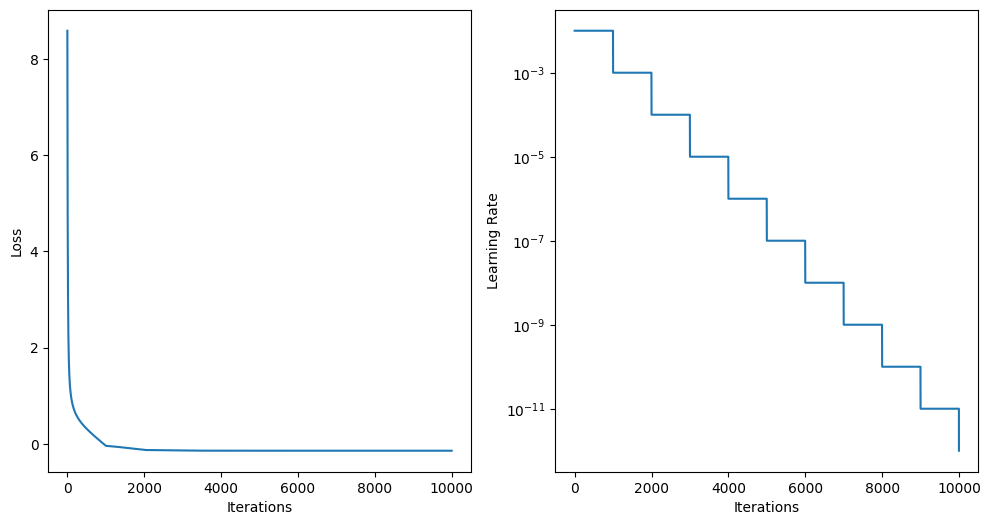

In [7]:
f, ax = plt.subplots(1, 2, figsize=(12, 6))
cbps.diagnose_loss(ax = ax[0], logscale=False)
cbps.diagnose_loss(ax = ax[1], only_lr=True)

### full kernel balancing

In [12]:
# centered and scaled X
normalised_x = (df[xn].values - df[xn].values.mean(axis=0)) / df[xn].values.std(axis=0)
from sklearn.metrics.pairwise import pairwise_kernels
X_= pairwise_kernels(normalised_x, metric="rbf", n_jobs=-1)

cbps = cbpys.CBPS(
    X=X_,
    W=w,
    estimand="ATT",
    intercept=True,
    noi=False,
    niter=10_000,
    reg = 0.001,
    scheduler=True,
)
weights = cbps.weights(numpy=True)

Optimizing CBPS...: 100%|██████████| 10000/10000 [00:12<00:00, 774.71it/s]


In [13]:
pd.DataFrame(np.c_[
  np.average(df.query("treatment == 0")[xyn].values, weights=weights, axis=0),
  df.query("treatment == 1")[xyn].mean().values,
], index = xyn, columns=["wtd_control", "treatment"])

,wtd_control,treatment
x1,0.917185,0.907298
x2,10.123920,10.123162
x3,0.219171,0.220331
x4,411.236349,410.947713
outcome,203.123085,200.567004
